In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics as metrics
import pickle
import time
from sklearn.kernel_approximation import RBFSampler
%matplotlib notebook


In [2]:
with open('screen_info.txt','rb') as fl:
    t = pickle.load(fl)
fnames = t[0]
totf = t[1]
binf = t[2]
runfile = 1
fname = fnames[runfile]
bf = binf[runfile]

### X_features are real valued features. We apply kernel on it 

In [3]:
path = os.getcwd() + '/bioassay-datasets/'
Y_fingerprints = []
X_features = []
labels = []
with open(path+fname+'red_train.csv') as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        Y_fingerprints.append(row[:bf])
        X_features.append(row[bf:-1])
        labels.append(row[-1])

In [4]:
Y_fingerprints = np.asarray(Y_fingerprints)[1:]
Y_fingerprints = Y_fingerprints.astype(int)

X_features = np.asarray(X_features)[1:]
X_features = X_features.astype(float)

#Normalise the features
#c_fingerprints = (c_fingerprints - np.mean(c_fingerprints,axis=0))/np.std(c_fingerprints,axis=0)

#p2_fingerprints = np.ones(p_fingerprints.shape)
(no_examples , ip_dim) = Y_fingerprints.shape
labels = labels[1:]
print(no_examples,ip_dim)
print("total no of 1s",np.sum(Y_fingerprints))
print("total no of 0s",no_examples*ip_dim-np.sum(Y_fingerprints))

(47831, 122)
('total no of 1s', 256419)
('total no of 0s', 5578963)


In [5]:
Y_fingerprints[(Y_fingerprints==0)] = -1

labels2 = np.zeros((len(labels),1))
for i,l in enumerate(labels):
    if l=='Active':
        labels2[i] = 1
    else:
        labels2[i] = 0
labels2 = labels2.astype(int)

In [6]:
feat_dim = 250

rbf_feature = RBFSampler(gamma=1,n_components = feat_dim, random_state=1)
c_fingerprints = rbf_feature.fit_transform(X_features)
p_fingerprints = rbf_feature.fit_transform(Y_fingerprints)

In [7]:
ind = np.arange(no_examples)
np.random.shuffle(ind)
p_fingerprints = p_fingerprints[ind]
c_fingerprints = c_fingerprints[ind]
labels2 = labels2[ind]

In [8]:
no_active_ele = (sum(labels2))
print(no_active_ele)
batch_size = 50

[170]


In [9]:
def get_train_batch(batch_size,validation_iter=0,binary=True):
    
    if validation_iter == 0: #no validation
        curr_data_size = no_examples
        labels_train = labels2
    else:
        curr_data_size = int(no_examples*0.8)
        interval_size = int(no_examples*0.2)
        
        if(val_iter==1):
            s_ind1 = int((validation_iter)*interval_size)
            end_ind1 = int((validation_iter+1)*interval_size)
            s_ind2 = int((validation_iter + 1) * interval_size)
            end_ind2 = int(no_examples)
        else:
            s_ind1 = 0
            end_ind1 = int((validation_iter)*interval_size)
            s_ind2 = int((validation_iter + 1) * interval_size)
            end_ind2 = int(no_examples)
        
        #print("train_ind ",s_ind1,end_ind1,s_ind2,end_ind2)
        indices = range(s_ind1,end_ind1) + range(s_ind2,end_ind2)
        c_train_data = c_fingerprints[indices]
        p_train_data = p_fingerprints[indices]
        labels_train = labels2[indices]
                               
    samples = np.random.randint(low=0,high=curr_data_size,size=(batch_size,1))
    if binary == True:
        train_batch = p_train_data[samples].reshape(batch_size,feat_dim)
        train_batch = train_batch.astype(int)
    else:
        train_batch = c_train_data[samples].reshape(batch_size,feat_dim)
        train_batch = train_batch.astype(float)
    
    train_batch = torch.cuda.FloatTensor(train_batch)
    train_batch = Variable(train_batch,requires_grad=False).cuda()
    target = Variable(torch.cuda.LongTensor(labels_train[samples]),requires_grad=False)
    target = target.view(batch_size,)
    return train_batch,target

In [10]:
def get_val_data(validation_iter,binary = True):
    interval_size = int(no_examples)*0.2
    s_ind = int((validation_iter-1)*interval_size)
    e_ind = int((validation_iter) * interval_size)
    if(binary==True):
        train_data = p_fingerprints[s_ind:e_ind]
    else:
        train_data = c_fingerprints[s_ind:e_ind]
    labels_val = labels2[s_ind:e_ind]   
    #print("val ind ",s_ind,e_ind)
    #print train_data.shape, labels_val.shape
    return Variable(torch.cuda.FloatTensor(train_data)),labels_val  

In [11]:
class c_mlp(nn.Module):
    def __init__(self):
        super(c_mlp,self).__init__()
        self.l1 = nn.Linear(feat_dim,1000)
        self.l2 = nn.Linear(1000,500)
        #self.l3 = nn.Linear(1000,500)
        self.l4 = nn.Linear(500,500)
        self.l5 = nn.Linear(500,50)
        self.l6 = nn.Linear(50,2)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        #x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = F.leaky_relu(self.l5(x))
        x = (self.l6(x))
        
        return x

('val iter: ', 1)
0.693598091602
0.661991357803
0.653741538525
0.695006847382
0.632223069668
0.62126916647
0.608780384064
0.591562509537
0.575014710426
0.550553679466
0.528011381626
0.510498344898
0.489499628544
0.474194258451
0.450387358665
0.742428302765
0.420911818743
0.403752863407
0.386009246111
0.36645668745
0.348912417889
0.334739655256
0.811350345612
0.824569165707
0.296966314316
0.28345900774
0.271971493959
0.2636051476
0.252322822809
0.24175567925
0.230697825551
0.220322430134
0.941382527351
0.204820036888
0.197312921286
0.190330252051
0.988002300262
0.182125270367
1.00761127472
0.17639760673
0.177097737789
0.171075999737
0.165385648608
0.160022735596
1.05263233185
0.158761918545
0.153168752789
0.149533674121
0.147193431854
0.146302223206
0.143398284912
0.142948076129
0.141521379352
0.139434635639
0.13624304533
0.133943378925
0.132659912109
0.131023228168
0.129462316632
0.128872945905
0.12765455246
1.48129451275
0.126044198871
0.124759197235
0.123448297381
0.121667310596


<IPython.core.display.Javascript object>


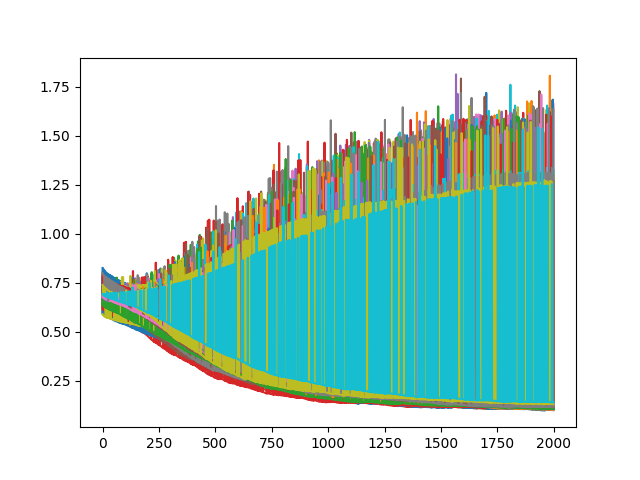

('tn, fp, fn, tp: ', array([9531,    0,   35,    0]))
0.755490064621
0.692668020725
0.713545143604
0.696305036545
0.674204647541
0.64303445816
0.615388274193
0.582977592945
0.542137801647
0.508370101452
0.476068198681
0.744139075279
0.422635674477
0.389500796795
0.360616147518
0.80962318182
0.826213121414
0.297778278589
0.280820727348
0.258668929338
0.245738327503
0.232515335083
0.225231513381
0.213706672192
0.208135396242
0.197724670172
0.186186224222
0.178749859333
0.171596705914
0.165069580078
1.05977332592
1.37496876717
0.157364904881
0.156815677881
0.157796382904
0.151930183172
0.149636730552
0.14543390274
0.143549114466
0.13817127049
0.13383205235
0.132617175579
0.131502553821
0.130455479026
0.126796096563
0.12334625423
0.123560123146
0.121227093041
1.18210160732
1.18088126183
0.119199827313
0.117179870605
0.115287780762
0.112984567881
0.110544592142
0.10997441411
0.108475513756
0.107293993235
1.22029423714
0.112965494394
0.111895650625
0.112710952759
0.111449569464
0.11135149002

0.121305063367
1.30825924873
('tn, fp, fn, tp: ', array([9531,    0,   35,    0]))
0.743912875652
0.726110219955
0.709159910679
0.691518425941
0.669805824757
0.647178709507
0.620063722134
0.590757131577
0.564094126225
0.539222657681
0.516866087914
0.489427268505
0.466620147228
0.442795068026
0.425365060568
0.404132157564
0.386987656355
0.364082694054
0.345700651407
0.336136221886
0.318525195122
0.304309844971
0.29240834713
0.271753966808
0.263669997454
0.994804024696
0.24103923142
0.232693046331
0.223190456629
0.217283532023
0.217328056693
0.206707298756
1.07781636715
0.197556644678
1.10059762001
0.186769485474
0.181189537048
0.178648144007
0.171412080526
1.17352628708
0.162650436163
0.158709540963
0.155014529824
0.154685825109
0.15233810246
0.149124071002
0.143149852753
0.143362820148
0.140966415405
1.26701521873
0.137033641338
1.26392972469
0.134286954999
1.58491683006
0.133212640882
1.29240489006
0.131259843707
0.12860019505
1.29652416706
0.127767160535
0.125843450427
0.122737810016

0.134238645434
1.22741627693
0.133454725146
0.131620004773
0.129861369729
0.129052147269
0.128087669611
('tn, fp, fn, tp: ', array([9529,    0,   37,    0]))
0.637903392315
0.619817912579
0.605067491531
0.714662015438
0.568614304066
0.550765752792
0.531316518784
0.507602632046
0.485572516918
0.461879312992
0.439690053463
0.419996857643
0.402188897133
0.379156082869
0.840575456619
0.346496880054
0.33219397068
0.31780898571
0.893447756767
0.296446174383
0.922593653202
0.270257204771
0.255975425243
0.248245537281
0.994787335396
0.232568755746
1.33554446697
1.03480517864
0.207174479961
0.203721046448
0.201762974262
0.196453720331
1.33024442196
0.192773669958
0.18502175808
0.177679628134
0.171824634075
0.169460356236
0.166233837605
0.160207688808
0.156785428524
0.155229568481
0.151893436909
0.152068912983
0.149900436401
0.148978635669
0.145266532898
0.14174644649
1.22421205044
0.136876985431
1.548635602
0.132732570171
1.71828329563
0.132712841034
1.2627286911
0.128976270556
0.12872838974
0.

0.125869736075
0.126270279288
0.126661926508
0.123905733228
1.23355865479
0.1217995435
0.120830535889
0.118435055017
1.25636029243
0.117549441755
1.25957417488
1.26524138451
('tn, fp, fn, tp: ', array([9531,    0,   35,    0]))
0.692304313183
0.673759698868
0.655229628086
0.635231077671
0.611719310284
0.588748991489
0.562280416489
0.542494416237
0.515614151955
0.490460693836
0.756779074669
0.442428946495
0.419303536415
0.399587929249
0.380941748619
0.358636260033
0.842484295368
0.328989058733
0.310336768627
0.288085788488
0.917526960373
0.264583617449
0.25545245409
0.24669380486
0.231492653489
0.227455794811
0.219382464886
0.211942851543
0.204216390848
0.199243217707
0.194636911154
0.194292455912
1.06019341946
0.184524178505
0.180653840303
0.175343498588
0.170105531812
0.162367284298
0.157148778439
0.156601727009
0.152862727642
0.152215003967
0.150665685534
0.148300975561
1.16707527637
0.147759929299
0.147661700845
0.145849779248
0.14473310113
0.141694396734
1.18932449818
1.18959259987

0.128169551492
0.126678287983
0.124733753502
1.18454384804
0.124410226941
0.124394915998
0.123175792396
0.122002452612
0.119469165802
0.121324516833
0.124671384692
0.121445327997
0.121114753187
0.122111774981
0.121740490198
0.121401935816
('tn, fp, fn, tp: ', array([9535,    0,   31,    0]))
0.675567388535
0.654295682907
0.636321783066
0.615097045898
0.587015807629
0.557600498199
0.52562135458
0.493288069963
0.455614507198
0.426872611046
0.401059985161
0.368627667427
0.348551571369
0.322484731674
0.300549387932
0.27800115943
0.262158721685
0.253397017717
0.238529548049
0.230809167027
0.220110282302
0.212595760822
1.01025271416
0.189911693335
0.18305772543
0.177303165197
1.06519794464
0.169814631343
0.165448248386
0.158870235085
0.151243671775
0.14537627995
0.141543209553
0.143398463726
0.138421073556
0.138175472617
0.138574138284
0.140703752637
0.137345939875
0.136171802878
0.133151605725
0.131279945374
0.126730039716
0.127039730549
0.124640464783
1.21906399727
0.12024076283
0.11995498

0.136345788836
0.131752789021
0.129064410925
0.125996097922
0.12780816853
0.125413820148
0.123147964478
0.12251394242
1.16636860371
0.119959659874
0.118740580976
0.115506649017
0.116550117731
0.113489538431
0.111244700849
0.110424429178
0.110938549042
1.20112776756
0.108145743608
('tn, fp, fn, tp: ', array([9535,    0,   32,    0]))
0.697443366051
0.693492889404
0.668157398701
0.695469975471
0.63286614418
0.728784739971
0.58692240715
0.565889060497
0.540042936802
0.510746598244
0.488720238209
0.466266036034
0.442191809416
0.414577841759
0.389092624187
0.370118737221
0.345678895712
0.324206233025
0.306284189224
0.293798208237
0.274875313044
0.263264030218
0.253140121698
0.241531416774
0.2313760221
0.225651696324
0.218726500869
0.209872305393
0.204192727804
0.194156587124
0.184878349304
0.178218066692
0.173549935222
0.16922621429
0.169546067715
0.164277374744
0.158709347248
0.15816257894
0.154771819711
0.149984359741
0.148314476013
0.146470054984
0.142042711377
0.138769075274
0.134822994

0.15977653861
0.156643807888
0.154598250985
1.19580352306
0.1526235044
0.147979184985
0.148157045245
0.14636516571
0.145730569959
0.144391834736
1.23167777061
0.140156194568
0.139778211713
1.24472641945
1.24321448803
0.135497868061
0.134337425232
0.134910985827
0.134744569659
0.132199287415
0.132633388042
('tn, fp, fn, tp: ', array([9535,    0,   32,    0]))
0.673793792725
0.662422716618
0.64940315485
0.638527572155
0.707651078701
0.610704362392
0.749229371548
0.577518165112
0.728969335556
0.539384901524
0.518939971924
0.498733609915
0.481065660715
0.460897833109
0.443003922701
0.423581689596
0.814505398273
0.388932734728
0.374509453773
0.36265617609
0.344172865152
0.324978798628
0.312594652176
0.302072435617
0.285335659981
0.274971336126
0.271033316851
0.263218849897
0.257542908192
0.25072363019
0.243144363165
0.236044690013
0.225829258561
1.26324498653
0.214890301228
1.07272958755
1.06866765022
1.07847070694
0.198227196932
0.19194303453
0.189685970545
0.186951294541
0.182946562767
0.

In [15]:
min_fn = 15
max_fp = 200
maxtmpdiff = -2
cm_list = []
get_model = 1
for val_iter in range(1,6):
    print("val iter: ",val_iter)
    
   
    #weights_array = [5]
    weights_array = np.linspace(50,70,10)
    for i,w in enumerate(weights_array):
        cost_graph = []
        mymlp = c_mlp().cuda()
        optimizer = torch.optim.Adagrad(mymlp.parameters(),lr=1e-4)
        criterion = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor([1,w]))

        epochs = 2000
        for ep in range(epochs):
            train_batch,target = get_train_batch(batch_size,binary = True,validation_iter = val_iter)
            model_op = mymlp(train_batch)
            #print(model_op.type)
            #print(target.type)
            loss = criterion(model_op,target)
            loss.backward()
            cost_graph.append(loss.cpu().data.numpy())
            optimizer.step()
            optimizer.zero_grad()

            if(ep%30==29):
                print(loss.data[0])

        plt.plot(range(epochs),cost_graph)
        plt.show()
        
        ## After training check on cross validation data
        val_data,labels_val = get_val_data(val_iter,binary = True)
        train_op = mymlp(val_data)
        train_op = train_op.cpu().data.numpy()
        pred_labels = np.argmax(train_op,axis=1)
        #tmp_labels = tmp_labels.data.cpu().numpy()
        #print(sum(tmp_labels))
        cf = metrics.confusion_matrix(labels_val,pred_labels).ravel()
        #print(val_iter,w)
        print('tn, fp, fn, tp: ',cf)
        [tn,fp,fn,tp] = cf
        wcf = [val_iter] + [w] + [cf]
        tmpdiff = tp-fn
        if(tmpdiff >= maxtmpdiff):
            cm_list.append(wcf)
            if(tmpdiff>= maxtmpdiff):
                if(fp <= max_fp):
                    max_fp = fp
                    maxtmpdiff = tmpdiff
                    model_path = os.getcwd() + '/kernel_mac' + fname + '_' + str(get_model)
                    torch.save(mymlp.state_dict(),model_path)
                    print("saving model on val: ",val_iter," and weight: ",w)
                    if(get_model<4):
                        get_model = get_model + 1
                    else:
                        break

### Test the model 

In [14]:
cost_graph

[Variable containing:
  0.6299
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6264
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6239
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6218
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6200
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6183
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6168
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6154
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6974
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6142
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6975
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6131
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6120
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0

In [ ]:
path = os.getcwd() + '/bioassay-datasets/'
p_fingerprints_test = []
X_features_test = []
labels_t = []
with open(path+fname+'red_test.csv') as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        p_fingerprints_test.append(row[:bf])
        X_features_test.append(row[bf:-1])
        labels_t.append(row[-1])

In [ ]:
p_fingerprints_test = np.asarray(p_fingerprints_test)[1:]
p_fingerprints_test = p_fingerprints_test.astype(int)

X_features_test = np.asarray(X_features_test)[1:]
X_features_test = X_features_test.astype(float)

#Normalise the features
#c_fingerprints = (c_fingerprints - np.mean(c_fingerprints,axis=0))/np.std(c_fingerprints,axis=0)

#p2_fingerprints = np.ones(p_fingerprints.shape)
(no_examples , ip_dim) = X_features_test.shape
labels_t = labels_t[1:]
print(no_examples,ip_dim)
print("total no of 1s",np.sum(p_fingerprints_test))
print("total no of 0s",no_examples*ip_dim-np.sum(p_fingerprints_test))

In [ ]:
p_fingerprints_test[(p_fingerprints_test==0)] = -1

labels2_t = np.zeros((len(labels_t),1))
for i,l in enumerate(labels_t):
    if l=='Active':
        labels2_t[i] = 1
    else:
        labels2_t[i] = 0
labels2_t = labels2_t.astype(int)

In [ ]:
feat_dim = 250

rbf_feature = RBFSampler(gamma=1,n_components = feat_dim, random_state=1)
trans = rbf_feature.fit(X_features)
c_fingerprints_test = trans.transform(X_features_test)

In [ ]:
testmlp = c_mlp().cuda()
model_path = os.getcwd() + '/kernel_mac' + fname + '_3'
testmlp.load_state_dict(torch.load(model_path))

In [ ]:
op = testmlp(Variable(torch.cuda.FloatTensor(c_fingerprints_test)))
op = op.cpu().data.numpy()
pred_labels = np.argmax(op,axis=1)
cf = metrics.confusion_matrix(labels2_t,pred_labels).ravel()
#print(val_iter,w)
print('tn, fp, fn, tp: ',cf)

In [ ]:
np.sum(labels2_t)